In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/data/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [8]:
image_dim = 784
hidden_dim = 512
latent_dim = 2

#### 初期化

* ネットワークの重みの初期値は
* 活性化関数に `ReLU` を使う場合は，He 初期化を使う

$$
\mathcal{N}\left(0, \sqrt{\frac{2}{n_i}} \right)
$$
ここで，$n_i$ は入力ユニット数．

* 活性化関数に `sigmoido` や `tanh` を使う場合は，Glorot の初期化を使う．

* Glorot の正規分布
$$
\mathcal{N}\left(0, \sqrt{\frac{2}{n_i + n_{i+1}}} \right)
$$
ここで，$n_i, n_{i+1}$ はそれぞれ入力ユニット数，出力ユニット数．

* 一様分布バージョンもある．
$$
U\left(-\sqrt{\frac{6}{n_i + n_{i+1}}}, \sqrt{\frac{6}{n_i + n_{i+1}}} \right)
$$

In [6]:
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [11]:
!mkdir -p ../images
!curl "http://www.renom.jp/ja/_images/fig3.png" -o "../images/variational_autoencoder.png"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55180  100 55180    0     0   478k      0 --:--:-- --:--:-- --:--:--  481k


## 変分オートエンコーダー

![変分オートエンコーダー](../images/variational_autoencoder.png)

In [16]:
# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps


# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [20]:
learning_rate = 0.001
num_steps = 30000
batch_size = 64

# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)


loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Step 1:, None Loss: 637.394592
Step 1000:, None Loss: 180.298141
Step 2000:, None Loss: 168.259491
Step 3000:, None Loss: 172.550232
Step 4000:, None Loss: 163.243134
Step 5000:, None Loss: 161.803192
Step 6000:, None Loss: 164.897156
Step 7000:, None Loss: 151.356674
Step 8000:, None Loss: 159.368927
Step 9000:, None Loss: 155.874573
Step 10000:, None Loss: 153.718597
Step 11000:, None Loss: 155.267853
Step 12000:, None Loss: 153.213501
Step 13000:, None Loss: 160.220184
Step 14000:, None Loss: 157.160034
Step 15000:, None Loss: 152.718231
Step 16000:, None Loss: 159.253906
Step 17000:, None Loss: 151.896179
Step 18000:, None Loss: 151.605347
Step 19000:, None Loss: 150.101547
Step 20000:, None Loss: 154.182312
Step 21000:, None Loss: 159.998352
Step 22000:, None Loss: 139.637650
Step 23000:, None Loss: 169.120300
Step 24000:, None Loss: 142.972641
Step 25000:, None Loss: 155.178848
Step 26000:, None Loss: 139.743500
Step 27000:, None Loss: 143.660492
Step 28000:, None Loss: 163.91247

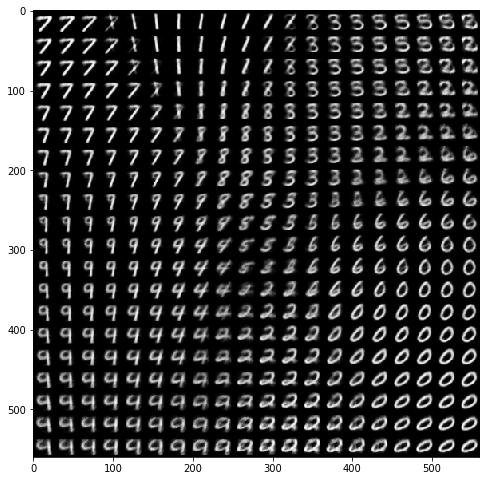

In [34]:

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)

        #
        t, l = sess.run([train_op, loss_op], feed_dict={input_image: batch_x})
        if i % 1000 == 0 or i == 1:
            print('Step %i:, %s Loss: %f' % (i, t, l))

    # Testing
    # Generator takes noise as input
    noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
    # Rebuild the decoder to create image from noise
    decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
    decoder = tf.nn.tanh(decoder)
    decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
    decoder = tf.nn.sigmoid(decoder)

    # Building a manifold of generated digits
    n = 20
    x_axis = np.linspace(-3, 3, n)
    y_axis = np.linspace(-3, 3, n)

    canvas = np.empty((28 * n, 28 * n))
    for i, yi in enumerate(x_axis):
        for j, xi in enumerate(y_axis):
            z_mu = np.array([[xi, yi]] * batch_size)
            x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
            canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
            x_mean[0].reshape(28, 28)

    plt.figure(figsize=(8, 10))
    Xi, Yi = np.meshgrid(x_axis, y_axis)
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()

In [22]:
np.array([[1, 2]] * 10)

array([[1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2]])

In [33]:
np.array([1,2,3])[None,:].shape

(1, 3)